#### This script integrates the new replicates into a joint embedding with the old replicates. This ultimately ends up getting recalculated at the end of the script 

In [1]:
import scanpy as sc
import scvi
from tqdm.notebook import tqdm
import os
import numpy as np
import pandas as pd
from scvi.model.utils import mde
import matplotlib.pyplot as plt
import pickle
import glob

import seaborn as sns
from sklearn.metrics import classification_report
import torch

/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [2]:
sc.set_figure_params(figsize=(4, 4))

Add the paths to all folders for experiments to be integrated

In [3]:
input_folders = glob.glob('/mnt/sata1/Analysis_Alex/timecourse_replicates/day*')

In [4]:
output_folder = r'/projects/2023_Spatial_Paper/Analysis_Alex/timecourse_replicates/analysis/cleaned'

put the path to the final adata from replicate 1 processing

In [ ]:
reference_adata = r'D:/amonell/timecourse_final/analysis/cleaned/final_celltyped_and_axes.h5ad'

Run scVI integration

In [7]:
scvi.model.SCVI.setup_anndata(reference_adata, batch_key="batch", layer="raw")

/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


In [8]:
torch.set_float32_matmul_precision('high')

In [9]:
scvi_ref = scvi.model.SCVI(reference_adata, n_layers=2, n_latent=30, gene_likelihood="nb")
scvi_ref.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 5/5: 100%|██████████| 5/5 [05:38<00:00, 63.76s/it, v_num=1, train_loss_step=113, train_loss_epoch=115]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [05:38<00:00, 67.72s/it, v_num=1, train_loss_step=113, train_loss_epoch=115]


In [10]:
SCVI_LATENT_KEY = "X_scVI_replicates"

reference_adata.obsm[SCVI_LATENT_KEY] = scvi_ref.get_latent_representation()
sc.pp.neighbors(reference_adata, use_rep=SCVI_LATENT_KEY)

/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


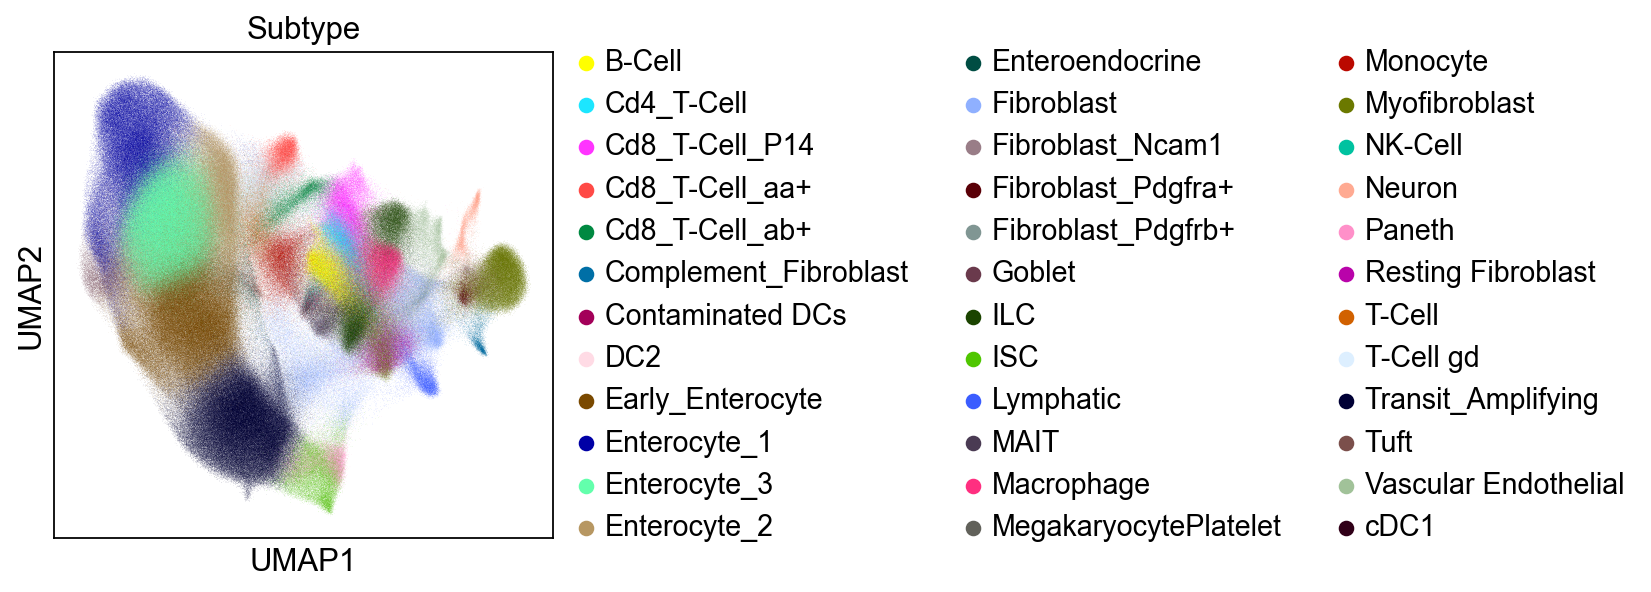

In [11]:
sc.tl.umap(reference_adata)
sc.pl.umap(reference_adata, color = 'Subtype')

### Map new replicates to this joint embedding

In [24]:

for t in range(len(input_folders)):
    target_adata = sc.read(os.path.join(input_folders[t], 'adatas', '05_unrolled.h5ad'))
    target_adata.obs['batch'] = os.path.basename(input_folders[t])
    scvi.model.SCVI.prepare_query_anndata(target_adata, scvi_ref)
    scvi_query = scvi.model.SCVI.load_query_data(
        target_adata,
        scvi_ref
    )

    scvi_query.train(max_epochs=200, plan_kwargs={"weight_decay": 0.0})
    target_adata.obsm[SCVI_LATENT_KEY] = scvi_query.get_latent_representation()
    target_adata.write(os.path.join(input_folders[t], 'adatas', '06_reference_mapped.h5ad'))

/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


INFO     Found 100.0% reference vars in query data.                                                                


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [29:47<00:00,  8.62s/it, v_num=1, train_loss_step=169, train_loss_epoch=166]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [29:47<00:00,  8.94s/it, v_num=1, train_loss_step=169, train_loss_epoch=166]


/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


INFO     Found 100.0% reference vars in query data.                                                                


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [27:58<00:00,  8.19s/it, v_num=1, train_loss_step=139, train_loss_epoch=138]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [27:58<00:00,  8.39s/it, v_num=1, train_loss_step=139, train_loss_epoch=138]


/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


INFO     Found 100.0% reference vars in query data.                                                                


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [27:00<00:00,  7.55s/it, v_num=1, train_loss_step=159, train_loss_epoch=133] 

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [27:00<00:00,  8.10s/it, v_num=1, train_loss_step=159, train_loss_epoch=133]


/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


INFO     Found 100.0% reference vars in query data.                                                                


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [21:29<00:00,  6.21s/it, v_num=1, train_loss_step=154, train_loss_epoch=151]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [21:29<00:00,  6.45s/it, v_num=1, train_loss_step=154, train_loss_epoch=151]
